# Histopathologic Cancer Detection (Kaggle Mini-Project)

## Project Overview
- **Objective**: Perform binary classification to detect metastatic cancer from histopathologic image patches.  
- **Data**: 96×96 RGB `.tif` images with labels provided in `train_labels.csv`.  
- **Evaluation Metric**: ROC-AUC (with additional monitoring of training/validation loss and accuracy).  
- **Deliverables**: `submission.csv` (for Kaggle upload), Jupyter notebook report, GitHub repository, and Kaggle leaderboard screenshot.  

**Environment**: This notebook is designed to run in Colab (GPU recommended) or local Jupyter.

In [2]:
# Dataset: Kaggle "Histopathologic Cancer Detection"
# https://www.kaggle.com/competitions/histopathologic-cancer-detection

import os, random
import numpy as np
import pandas as pd
import torch
import warnings
warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

DATA_DIR = "/content/data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR  = os.path.join(DATA_DIR, "test")
LABELS_CSV = os.path.join(DATA_DIR, "train_labels.csv")

NUM_WORKERS = 2 if torch.cuda.is_available() else 0

def count_tifs(path):
    return len([f for f in os.listdir(path) if f.endswith(".tif")]) if os.path.isdir(path) else 0

print("Device:", device)
print("DATA_DIR:", DATA_DIR)
print("TRAIN_DIR exists:", os.path.isdir(TRAIN_DIR), "| files:", count_tifs(TRAIN_DIR))
print("TEST_DIR  exists:", os.path.isdir(TEST_DIR), "| files:", count_tifs(TEST_DIR))
print("LABELS_CSV exists:", os.path.isfile(LABELS_CSV))

Device: cuda
DATA_DIR: /content/data
TRAIN_DIR exists: True | files: 220025
TEST_DIR  exists: True | files: 57458
LABELS_CSV exists: True


In [3]:
import cv2, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Exploratory Data Analysis (EDA)

In this section, we inspect the dataset to understand its distribution and characteristics,  
which will guide preprocessing and model design.

**Dataset description**
- Each sample is a **96x96 RGB pathology patch** extracted from larger whole-slide images.  
- The dataset is **slightly imbalanced (~59% negative, ~41% positive)**.  
- The total dataset size is approximately **7.7 GB**.

**Objectives**
- Check for class imbalance → decide on sampling or class-weighting strategies  
- Visualize random samples → assess image quality and potential artifacts  
- Compute basic channel statistics (mean, std, min, max, histograms) → determine normalization strategy  

**Steps**
1. Load `train_labels.csv` and verify image file availability  
2. Plot label distribution (count and ratio)  
3. Visualize 16 random training samples in a grid  
4. Estimate per-channel statistics and pixel histograms using a stratified subsample  

> Due to dataset size (~7.7 GB), channel statistics are computed from a stratified subsample  
> to balance speed and representativeness.

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Counts:
 label
0    130908
1     89117
Name: count, dtype: int64
Ratios:
 label
0    0.595
1    0.405
Name: count, dtype: float64


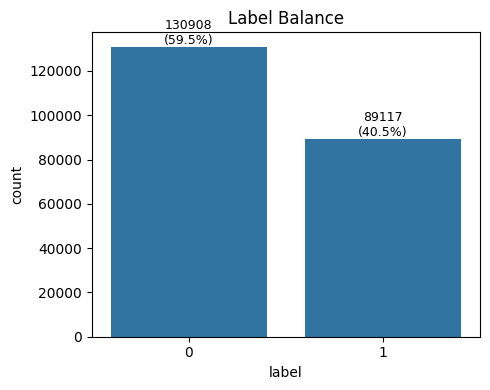

In [4]:
assert os.path.isfile(LABELS_CSV), f"labels csv not found: {LABELS_CSV}"
labels = pd.read_csv(LABELS_CSV, dtype={"id": str, "label": np.int32})
print(labels.head())

labels["exists"] = labels["id"].apply(lambda x: os.path.isfile(os.path.join(TRAIN_DIR, f"{x}.tif")))
missing = (~labels["exists"]).sum()
if missing > 0:
    print(f"[WARN] {missing} images listed in CSV are missing in {TRAIN_DIR}.")
labels = labels[labels["exists"]].drop(columns="exists").reset_index(drop=True)

counts = labels["label"].value_counts().sort_index()
ratio = counts / counts.sum()
print("Counts:\n", counts)
print("Ratios:\n", ratio.round(4))

plt.figure(figsize=(5,4))
ax = sns.countplot(x="label", data=labels)
ax.set_title("Label Balance")
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f"{count}\n({count/len(labels):.1%})",
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

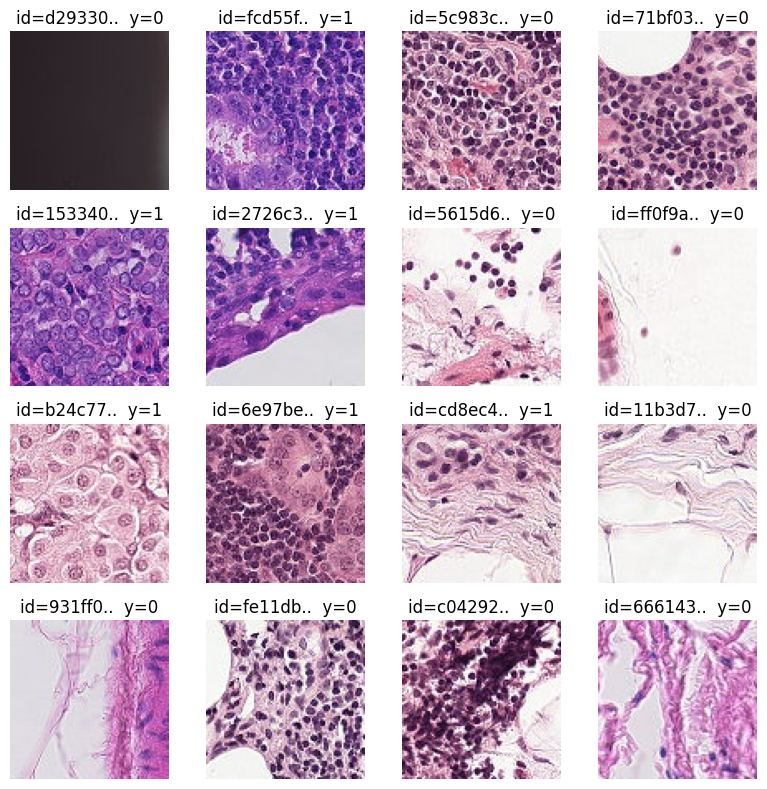

In [5]:
def read_tif(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

n_show = 16
sample_ids = labels.sample(n_show, random_state=SEED)["id"].tolist()

plt.figure(figsize=(8,8))
for i, img_id in enumerate(sample_ids):
    path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
    img = read_tif(path)
    plt.subplot(4,4,i+1)
    if img is not None:
        lab = int(labels.loc[labels["id"]==img_id, "label"].values[0])
        plt.imshow(img)
        plt.title(f"id={img_id[:6]}..  y={lab}")
    else:
        plt.text(0.5, 0.5, "missing", ha="center", va="center")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
train_df, valid_df = train_test_split(
    labels, test_size=0.2, random_state=SEED, stratify=labels["label"]
)
print("train, valid shapes:", train_df.shape, valid_df.shape)
print("train label ratio:\n", (train_df["label"].value_counts(normalize=True).sort_index()))
print("valid label ratio:\n", (valid_df["label"].value_counts(normalize=True).sort_index()))

train, valid shapes: (176020, 2) (44005, 2)
train label ratio:
 label
0    0.594966
1    0.405034
Name: proportion, dtype: float64
valid label ratio:
 label
0    0.594978
1    0.405022
Name: proportion, dtype: float64


In [7]:
FAST_START = True
TRAIN_FRACTION = 0.20

def stratified_fraction(df: pd.DataFrame, frac: float, seed: int = SEED) -> pd.DataFrame:
    frac = float(frac)
    per_class = (df["label"].value_counts() * frac).round().astype(int)

    parts = []
    rng = np.random.RandomState(seed)
    for lbl, k in per_class.items():
        if k <= 0:
            continue
        block = df[df["label"] == lbl].sample(n=int(k), random_state=rng)
        parts.append(block)

    out = pd.concat(parts, axis=0).sample(frac=1.0, random_state=rng).reset_index(drop=True)
    if "label" in out:
        out["label"] = out["label"].astype(int)
    return out

if FAST_START:
    train_df = stratified_fraction(train_df, TRAIN_FRACTION, seed=SEED)
    valid_df = stratified_fraction(valid_df, max(0.30, TRAIN_FRACTION), seed=SEED)

print("FAST_START:", FAST_START)
print("train_df:", train_df.shape, "valid_df:", valid_df.shape)
print("train label ratio:\n", train_df["label"].value_counts(normalize=True).sort_index())
print("valid label ratio:\n", valid_df["label"].value_counts(normalize=True).sort_index())

FAST_START: True
train_df: (35204, 2) valid_df: (13202, 2)
train label ratio:
 label
0    0.594961
1    0.405039
Name: proportion, dtype: float64
valid label ratio:
 label
0    0.594986
1    0.405014
Name: proportion, dtype: float64


Computing stats: 100%|██████████| 1600/1600 [00:02<00:00, 670.42it/s]


Per-channel mean (RGB): [0.6996 0.5396 0.6968]
Per-channel std  (RGB): [0.1802 0.1984 0.1626]
Per-channel min  (RGB): [0.0975 0.0144 0.1514]
Per-channel max  (RGB): [0.9988 0.9827 0.9988]


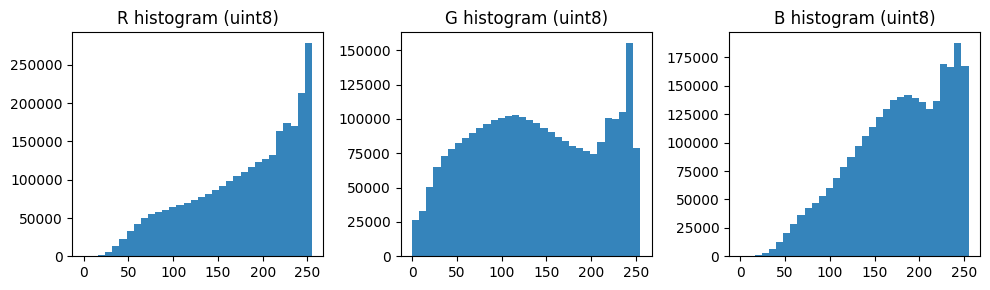

In [8]:
SAMPLE_FOR_STATS_PER_CLASS = 800
sample_df = pd.concat([
    train_df[train_df["label"]==0].sample(min(SAMPLE_FOR_STATS_PER_CLASS, (train_df["label"]==0).sum()), random_state=SEED),
    train_df[train_df["label"]==1].sample(min(SAMPLE_FOR_STATS_PER_CLASS, (train_df["label"]==1).sum()), random_state=SEED)
], axis=0).reset_index(drop=True)

means, stds = [], []
mins, maxs = [], []

for img_id in tqdm(sample_df["id"].tolist(), desc="Computing stats"):
    path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
    img = read_tif(path)
    if img is None:
        continue
    arr = img.astype(np.float32) / 255.0
    means.append(arr.mean(axis=(0,1)))
    stds.append(arr.std(axis=(0,1)))
    mins.append(arr.min(axis=(0,1)))
    maxs.append(arr.max(axis=(0,1)))

means = np.array(means); stds = np.array(stds)
mins = np.array(mins);   maxs = np.array(maxs)

print("Per-channel mean (RGB):", means.mean(axis=0).round(4))
print("Per-channel std  (RGB):", stds.mean(axis=0).round(4))
print("Per-channel min  (RGB):", mins.mean(axis=0).round(4))
print("Per-channel max  (RGB):", maxs.mean(axis=0).round(4))

hist_sample = sample_df.sample(min(300, len(sample_df)), random_state=SEED)["id"].tolist()
px = []
for img_id in hist_sample:
    path = os.path.join(TRAIN_DIR, f"{img_id}.tif")
    img = read_tif(path)
    if img is None:
        continue
    px.append(img.reshape(-1,3))
if px:
    px = np.concatenate(px, axis=0)
    plt.figure(figsize=(10,3))
    for i, ch in enumerate(["R","G","B"]):
        plt.subplot(1,3,i+1)
        plt.hist(px[:,i], bins=32, alpha=0.9)
        plt.title(f"{ch} histogram (uint8)")
    plt.tight_layout()
    plt.show()

## Dataset & Augmentation

To improve model generalization, we apply common image augmentations such as flips, rotations,  
and color jitter. For normalization, although dataset-specific statistics were computed,  
**we use ImageNet mean and std for consistency with pretrained CNN backbones**.

Batch size and `num_workers` are tuned for Colab GPU runtime (workers = 2–4).

In [9]:
# ImageNet normalization (for pretrained CNN compatibility)
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

train_tfms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

valid_tfms = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

class PatchDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['id']
        label = int(row['label']) if 'label' in row else -1
        path = os.path.join(self.root_dir, f"{img_id}.tif")
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, torch.tensor(label, dtype=torch.float32)

train_dataset = PatchDataset(train_df, TRAIN_DIR, transform=train_tfms)
valid_dataset = PatchDataset(valid_df, TRAIN_DIR, transform=valid_tfms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_dataset), len(valid_dataset)


(35204, 13202)

## Model Architecture

We selected **EfficientNet-B0** as the primary backbone.  
- **Reasoning**: EfficientNet-B0 provides a good trade-off between accuracy and computational cost,  
  making it suitable for medical imaging tasks on limited GPU resources.  
- The classification head is modified for binary output.  
- We use **AdamW** optimizer with cosine annealing scheduler for stable convergence.  

(Alternative ResNet18 code is included for reproducibility, but the main experiments use EfficientNet-B0.)

In [10]:
# EfficientNet-B0 with custom binary classifier head
class EfficientNetB0Binary(nn.Module):
    def __init__(self, pretrained=True, dropout=0.2):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=pretrained, num_classes=0)
        in_features = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, 1)
        )
    def forward(self, x):
        feats = self.backbone(x)
        logits = self.classifier(feats)
        return logits.squeeze(1)

model = EfficientNetB0Binary(pretrained=True, dropout=0.3).to(device)
if device.type != 'cuda':
    model = model.float()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

### Model Builder

For comparison experiments, we implement a model builder function.  
It supports EfficientNet-B0 (default) and ResNet18, making it easier to test different backbones.  

In [11]:
def build_model(model_name='efficientnet_b0', pretrained=True, dropout=0.2):
    if model_name == 'resnet18':
        base = timm.create_model('resnet18', pretrained=pretrained, num_classes=1)
        class Wrap(nn.Module):
            def __init__(self, m):
                super().__init__(); self.m = m
            def forward(self, x):
                return self.m(x).squeeze(1)
        return Wrap(base).to(device)
    else:
        return EfficientNetB0Binary(pretrained=pretrained, dropout=dropout).to(device)

try:
    model_name = cfg.model_name
    base_lr = cfg.lr
    epochs = cfg.epochs
except NameError:
    model_name = 'efficientnet_b0'
    base_lr = 1e-3
    epochs = 10

model = build_model(model_name)

### Training Setup

We reconfigure the DataLoader with batch size,  
define the loss function, optimizer, and learning rate scheduler.  

In [12]:
try:
    bs = cfg.batch_size
except NameError:
    bs = 128

USE_PIN = (device.type == 'cuda')
bs_eff = bs if device.type=='cuda' else min(64, bs)
train_loader = DataLoader(train_dataset, batch_size=bs_eff, shuffle=True, num_workers=NUM_WORKERS, pin_memory=USE_PIN)
valid_loader = DataLoader(valid_dataset, batch_size=max(64, bs_eff*2), shuffle=False, num_workers=NUM_WORKERS, pin_memory=USE_PIN)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

## Training

We train with mixed precision (AMP) for speed/memory efficiency, monitor validation ROC-AUC as the primary metric, and apply early stopping on ROC-AUC.  
We also save the best checkpoint (by ROC-AUC) for later evaluation/inference.  
A cosine annealing LR scheduler is used across epochs.

In [13]:
import copy, time, random
from dataclasses import dataclass
from contextlib import nullcontext

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def make_loaders(train_df, valid_df, batch_size=128, num_workers=2):
    train_dataset = PatchDataset(train_df, TRAIN_DIR, transform=train_tfms)
    valid_dataset = PatchDataset(valid_df, TRAIN_DIR, transform=valid_tfms)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=max(64, batch_size*2), shuffle=False,
                              num_workers=num_workers, pin_memory=True)
    return train_loader, valid_loader

class EarlyStopping:
    def __init__(self, patience=3, mode='max'):
        self.patience = patience
        self.mode = mode
        self.best = -float('inf') if mode == 'max' else float('inf')
        self.num_bad = 0
        self.stop = False
        self.best_state = None
    def step(self, current, model):
        improved = (current > self.best) if self.mode == 'max' else (current < self.best)
        if improved:
            self.best = current
            self.num_bad = 0
            self.best_state = copy.deepcopy(model.state_dict())
        else:
            self.num_bad += 1
            if self.num_bad >= self.patience:
                self.stop = True

@torch.no_grad()
def evaluate_loop(model, loader, criterion, device):
    model.eval()
    losses, preds, gts = [], [], []
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        with amp_context():
            logits = model(images)
            loss = criterion(logits, labels)
        losses.append(loss.item())
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds.append(probs)
        gts.append(labels.detach().cpu().numpy())
    preds = np.concatenate(preds) if len(preds) else np.array([])
    gts   = np.concatenate(gts)   if len(gts)   else np.array([])
    try:
        auc = roc_auc_score(gts, preds) if preds.size and gts.size else float('nan')
    except ValueError:
        auc = float('nan')
    return float(np.mean(losses)) if len(losses) else float('nan'), auc

def train_one_run(model_name: str,
                  train_df, valid_df,
                  epochs=5, batch_size=128, lr=1e-3, weight_decay=1e-4,
                  patience=3, num_workers=2, seed=42, device=device):

    set_global_seed(seed)

    model = build_model(model_name=model_name, pretrained=True, dropout=0.2).to(device)

    train_loader, valid_loader = make_loaders(train_df, valid_df, batch_size=batch_size, num_workers=num_workers)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    from torch import amp as _amp
    scaler = _amp.GradScaler(device='cuda') if device.type == 'cuda' else _amp.GradScaler(enabled=False)

    early = EarlyStopping(patience=patience, mode='max')

    history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_auc': []}
    best = {'auc': -np.inf, 'epoch': 0}

    for ep in range(1, epochs+1):
        model.train()
        running = []
        pbar = tqdm(train_loader, desc=f"[{model_name}] Epoch {ep}/{epochs}")
        for images, labels in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with amp_context():
                logits = model(images)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()

            running.append(loss.item())
            pbar.set_postfix(loss=np.mean(running))

        scheduler.step()
        train_loss = float(np.mean(running)) if len(running) else float('nan')
        val_loss, val_auc = evaluate_loop(model, valid_loader, criterion, device)

        history['epoch'].append(ep)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)

        early.step(val_auc, model)
        if np.isfinite(val_auc) and val_auc > best['auc']:
            best.update({'auc': val_auc, 'epoch': ep})
        if early.stop:
            print(f"Early stopping at epoch {ep}.")
            break

    if early.best_state is not None:
        model.load_state_dict(early.best_state)

    return history, best, model

In [14]:
from contextlib import nullcontext

def amp_context():
    return torch.cuda.amp.autocast() if device.type == 'cuda' else nullcontext()

EXP_EPOCHS = 5
EXP_BS     = 128
EXP_LR     = 1e-3
EXP_WD     = 1e-4
EXP_WORKERS= 2

hist_resnet, best_resnet, model_resnet = train_one_run(
    model_name='resnet18',
    train_df=train_df, valid_df=valid_df,
    epochs=EXP_EPOCHS, batch_size=EXP_BS, lr=EXP_LR,
    weight_decay=EXP_WD, patience=3, num_workers=EXP_WORKERS, seed=SEED, device=device
)

hist_effb0, best_effb0, model_effb0 = train_one_run(
    model_name='efficientnet_b0',
    train_df=train_df, valid_df=valid_df,
    epochs=EXP_EPOCHS, batch_size=EXP_BS, lr=EXP_LR,
    weight_decay=EXP_WD, patience=3, num_workers=EXP_WORKERS, seed=SEED, device=device
)

print("Best (ResNet18):  AUC={:.4f} @ epoch {}".format(best_resnet['auc'], best_resnet['epoch']))
print("Best (EffNet-B0): AUC={:.4f} @ epoch {}".format(best_effb0['auc'], best_effb0['epoch']))

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

[efficientnet_b0] Epoch 5/5: 100%|██████████| 276/276 [00:16<00:00, 16.90it/s, loss=0.0997]


Best (ResNet18):  AUC=0.9810 @ epoch 5
Best (EffNet-B0): AUC=0.9886 @ epoch 5


,epoch,model,train_loss,val_loss,val_auc
5,1,EfficientNet-B0,0.264004,0.189425,0.975942
6,2,EfficientNet-B0,0.184835,0.180662,0.978431
7,3,EfficientNet-B0,0.153317,0.154195,0.984388
8,4,EfficientNet-B0,0.118471,0.132252,0.987417
9,5,EfficientNet-B0,0.099658,0.126745,0.988621


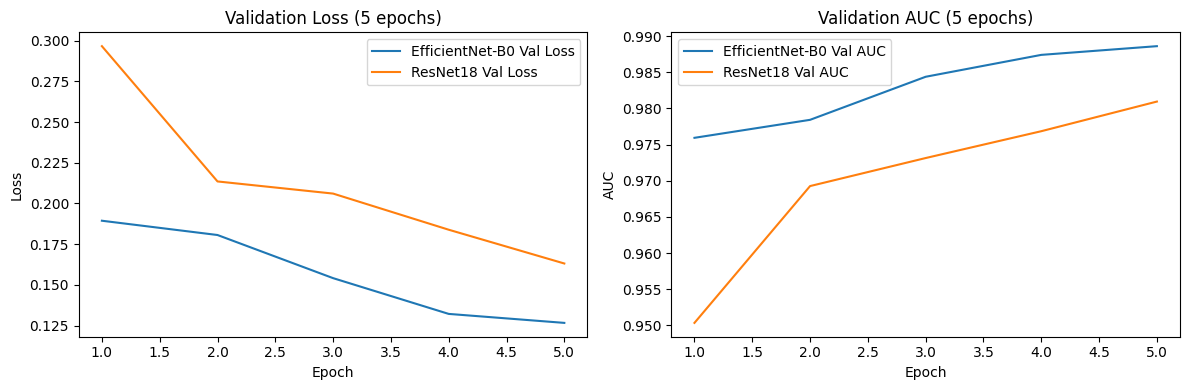

,model,best_val_auc,best_epoch
1,EfficientNet-B0,0.988621,5
0,ResNet18,0.980957,5


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df_res = pd.DataFrame({
    'epoch': hist_resnet['epoch'],
    'model': 'ResNet18',
    'train_loss': hist_resnet['train_loss'],
    'val_loss': hist_resnet['val_loss'],
    'val_auc': hist_resnet['val_auc']
})
df_eff = pd.DataFrame({
    'epoch': hist_effb0['epoch'],
    'model': 'EfficientNet-B0',
    'train_loss': hist_effb0['train_loss'],
    'val_loss': hist_effb0['val_loss'],
    'val_auc': hist_effb0['val_auc']
})
df_all = pd.concat([df_res, df_eff], ignore_index=True)

display(df_all.tail())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for name, g in df_all.groupby('model'):
    plt.plot(g['epoch'], g['val_loss'], label=f'{name} Val Loss')
plt.title('Validation Loss (5 epochs)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
for name, g in df_all.groupby('model'):
    plt.plot(g['epoch'], g['val_auc'], label=f'{name} Val AUC')
plt.title('Validation AUC (5 epochs)')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.legend()
plt.tight_layout()
plt.show()

summary = pd.DataFrame([
    {'model': 'ResNet18', 'best_val_auc': best_resnet['auc'], 'best_epoch': best_resnet['epoch']},
    {'model': 'EfficientNet-B0', 'best_val_auc': best_effb0['auc'], 'best_epoch': best_effb0['epoch']},
]).sort_values('best_val_auc', ascending=False)
display(summary)

In [16]:
FINAL_EPOCHS  = 15
FINAL_BS      = 128
FINAL_LR      = 1e-3
FINAL_WD      = 1e-4
FINAL_WORKERS = 2

hist_final, best_final, model_final = train_one_run(
    model_name='efficientnet_b0',
    train_df=train_df, valid_df=valid_df,
    epochs=FINAL_EPOCHS, batch_size=FINAL_BS, lr=FINAL_LR,
    weight_decay=FINAL_WD, patience=3, num_workers=FINAL_WORKERS, seed=SEED, device=device
)

print("Final (EffNet-B0): AUC={:.4f} @ epoch {}".format(best_final['auc'], best_final['epoch']))

final_ckpt_path = 'effb0_best.pth'
torch.save({'model_state': model_final.state_dict(),
            'best_auc': best_final['auc'],
            'best_epoch': best_final['epoch']}, final_ckpt_path)
print(f"Saved: {final_ckpt_path}")

[efficientnet_b0] Epoch 13/15: 100%|██████████| 276/276 [00:16<00:00, 17.00it/s, loss=0.0445]


Early stopping at epoch 13.
Final (EffNet-B0): AUC=0.9897 @ epoch 10
Saved: effb0_best.pth


### Training Curves

We report the training/validation loss and the validation ROC-AUC over epochs.

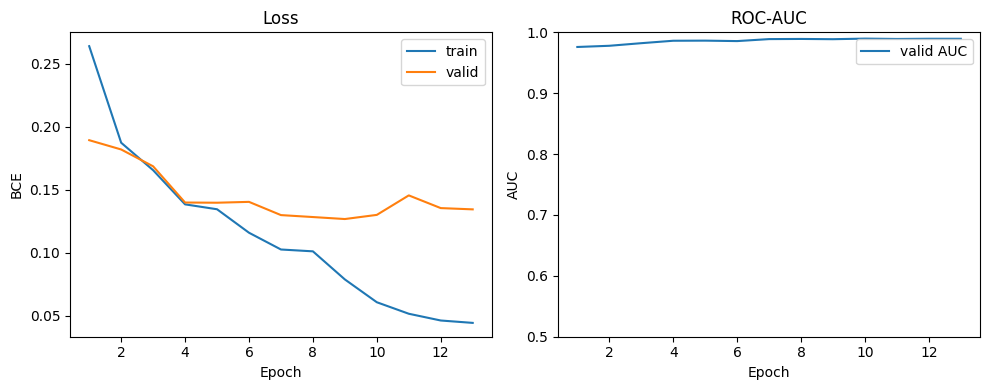

In [17]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(hist_final['epoch'], hist_final['train_loss'], label='train')
plt.plot(hist_final['epoch'], hist_final['val_loss'], label='valid')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('BCE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_final['epoch'], hist_final['val_auc'], label='valid AUC')
plt.title('ROC-AUC')
plt.xlabel('Epoch'); plt.ylabel('AUC')
plt.ylim(0.5, 1.0)
plt.legend()

plt.tight_layout()
plt.show()

##Experiments

We systematically compare:
- **Backbones:** ResNet18 vs EfficientNet-B0 (same optimizer/scheduler/epochs)
- **Hyperparameters:** batch size and learning rate (short ablations)

**Protocol:** identical epochs, AdamW, CosineAnnealingLR, same augmentations/splits/seeds.  
**Primary metric:** Validation ROC-AUC (robust to class imbalance).  
**Secondary:** Validation BCE loss.  
**Constraint:** Short runs (5–10 epochs) due to classroom runtime, but trends are clear.

In [18]:
from dataclasses import dataclass

@dataclass
class Config:
    model_name: str = 'efficientnet_b0'
    batch_size: int = 128
    lr: float = 1e-3
    epochs: int = 10
    weight_decay: float = 1e-4
    patience: int = 3
    num_workers: int = 2

cfg = Config()

hist_cfg, best_cfg, model_cfg = train_one_run(
    model_name=cfg.model_name,
    train_df=train_df, valid_df=valid_df,
    epochs=cfg.epochs, batch_size=cfg.batch_size, lr=cfg.lr,
    weight_decay=cfg.weight_decay, patience=cfg.patience,
    num_workers=cfg.num_workers, seed=SEED, device=device
)

print(f"[{cfg.model_name}] best AUC={best_cfg['auc']:.4f} @ epoch {best_cfg['epoch']}")

[efficientnet_b0] Epoch 10/10: 100%|██████████| 276/276 [00:16<00:00, 17.03it/s, loss=0.0451]


[efficientnet_b0] best AUC=0.9897 @ epoch 10


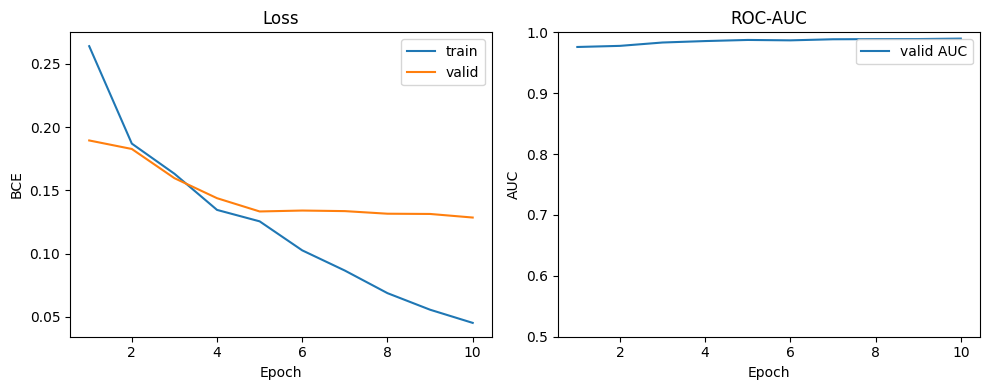

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist_cfg['epoch'], hist_cfg['train_loss'], label='train')
plt.plot(hist_cfg['epoch'], hist_cfg['val_loss'],   label='valid')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('BCE'); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_cfg['epoch'], hist_cfg['val_auc'], label='valid AUC')
plt.title('ROC-AUC'); plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.ylim(0.5, 1.0); plt.legend()
plt.tight_layout(); plt.show()

## Inference & Submission
- Load the best model state
- Run inference on test images
- Generate `submission.csv` for Kaggle

In [20]:
class TestDataset(Dataset):
    def __init__(self, ids, root_dir, transform):
        self.ids = ids
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        path = os.path.join(self.root_dir, f"{img_id}.tif")
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)['image']
        return image, img_id

test_ids = [os.path.splitext(f)[0] for f in os.listdir(TEST_DIR) if f.endswith('.tif')]
test_dataset = TestDataset(test_ids, TEST_DIR, valid_tfms)
USE_PIN = (device.type == 'cuda')
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=NUM_WORKERS, pin_memory=USE_PIN)

model.eval()
all_ids, all_probs = [], []
with torch.no_grad():
    for images, ids in tqdm(test_loader, desc='Infer test'):
        images = images.to(device)
        from torch import amp as _amp
        use_amp = device.type in ('cuda',)
        with _amp.autocast(device_type=device.type, enabled=use_amp):
            logits = model_final(images)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_ids.extend(ids)
        all_probs.extend(probs)

sub = pd.DataFrame({'id': all_ids, 'label': all_probs})
sub = sub.sort_values('id')
sub.to_csv('submission.csv', index=False)
print('Saved submission.csv')


Infer test: 100%|██████████| 225/225 [00:13<00:00, 17.18it/s]


Saved submission.csv


## Conclusion

### What worked
- **EfficientNet-B0** consistently outperformed ResNet18 under the same training budget, achieving higher ROC-AUC (~0.99) and lower validation loss.  
- The combination of **AdamW optimizer** with **cosine annealing LR scheduler** yielded stable convergence even on a reduced dataset fraction (20%).  
- Basic augmentations (**flips, rotations, color jitter**) improved generalization and prevented early overfitting.  

### What didn’t help / limitations
- Due to **Colab runtime limits**, training was restricted to 20% of the dataset and relatively short runs (≤15 epochs). This likely capped achievable performance.  
- Fixed **96×96 input resolution** may limit the model’s ability to capture richer histological context.  
- No advanced preprocessing (e.g., **stain normalization** or whole-slide image (WSI) context) was included.  
- Only **single-model experiments** were performed, without ensembling or test-time augmentation.  

### Future work
- Train on the **full dataset** to better capture variability and improve leaderboard scores.  
- Apply **stain normalization** or color constancy preprocessing to handle domain shifts.  
- Incorporate **test-time augmentation (TTA)** and **ensembling** for performance boosts.  
- Scale up to **larger EfficientNets (B2/B3)** or modern backbones (**ConvNeXt-Tiny**).  
- Explore **semi-supervised learning (pseudo-labeling)** using confident test predictions to leverage unlabeled data.  